# Clustering of Samples 

## Using k-means to cluster audio samples

This is an exploration of using k-means as a way of clustering untagged samples around centroids. There are three major groupings known in the audio clips: 

- Dialogue: only dialogue and ambient sounds typical to radio journalism
- Music: only music
- Both: a mixture of Dialogue and Music mixed together

It is logical that there should be three clusters in the data set, but it is unknown if the chosen extracted audio features will represent this. This EDA will help determine the optimum number of clusters to use over this sample set.

## Questions

**How to determine when [range normalization](#feature-normalization) is needed?**

Is this related to the Principal Component Analysis and centering around the origin as Scikit-Learn assumes (HOML p245)?


In [1]:
from pathlib import Path
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from joblib import Parallel, delayed
import logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap


In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### Feature Extraction 

Extract the following audio audio features:

- MFCCs: Mel-Frequency Cepstral Coefficients (13 features)
    - widely used in speech and audio processing; measure the power spectrum and capture tonal and timbral features
- ZCR: Zero-Corssing Rate (1 feature)
    - how often the signal amplitude switches across zero; can be used for identifying harmonic features
- Spectral Contrast: mean of each 7 spectral bands (7 features)
    - measures difference in amplitude across different frequencies; music tends to have richer harmonic structure which is reflected in spectral contrast
- Chroma Features: mean of chroma bins (12 features)
    - intensity of the audio signal in 12 pitch classes common in western music; reflects tonal content common in music, but lacking in dialogue
- RMS Energy: Root Mean Square Energy (1 feature)
    - average power of the audio signal over time also known as "loudness"; speech tends to be more dynamic in this domain
- Spectral Rolloff: (1 feature)
    - frequency below which 85% of total spectral energy is contained; music tends to have a broader frequency range
 
After unsatisfying clustering results, add additional features:

- Spectral Bandwidth:
    - width of spectral range; music typically has a wider bandwidth
- Spectral Centroid:
    - center of mass in the spectrum and brightness of sound; music typically has a hihger brightness
<!-- - Tempo:
    - rythmic structure -->
- HNR: Harmonic-to-Noise-Ratio
    - speech has more harmonic structure

In [3]:
def extract_features(file_path):
    """
    Extracts audio features from a given audio file.

    Parameters:
    file_path (Path): Path to the audio file.

    Returns:
    numpy.ndarray: Feature vector containing consistently reduced audio features.
    """
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs (mean and standard deviation of each coefficient across time)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Extract Zero-Crossing Rate (mean)
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    # Extract Spectral Contrast (mean)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

    # Extract Chroma Features (mean)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Combine selected features into a single feature vector
    features = np.concatenate((
        mfccs_mean,
        [zcr_mean],
        spectral_contrast_mean,
        chroma_mean
    ))

    return features

In [4]:
# Extract features from all audio files
def extract_features_from_directory(audio_dir):
    """
    Extracts features from all audio files in a given directory using parallel processing to utilize multiple cores.

    Parameters:
    audio_dir (Path): Path to the directory containing audio files.

    Returns:
    tuple: A tuple containing a numpy array of feature vectors and a list of filenames.
    """
    filenames = [filename for filename in audio_dir.iterdir() if filename.suffix == '.mp3']
    
    logging.info(f'Found {len(filenames)} audio files in {audio_dir}')
    
    # Use tqdm to show progress indicator
    feature_list = Parallel(n_jobs=-1)(delayed(extract_features)(filename) for filename in tqdm(filenames, desc='Extracting features'))
    
    return np.array(feature_list), filenames

### Process the training data

Initial feature extraction from all samples

In [5]:
# Directory containing your audio files
audio_dir = Path('./TRAINING_DATA/PREPARED/outro')  # Update this path if needed

# Extract features from audio files
features, filenames = extract_features_from_directory(audio_dir)

2024-11-03 14:00:47,297 - INFO - Found 1370 audio files in TRAINING_DATA/PREPARED/outro


Extracting features:   0%|          | 0/1370 [00:00<?, ?it/s]

<a id="feature-normalization"></a>
### Feature Normalization

Normalize the range so that each feature has a mean of 0 and a standard deviation of 1, which ensures that all features contribute equally to the clustering process.


In [6]:
# Normalize features 
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

### Exploring the Principal Component Analysis variance

The amount of variance is plotted against the number of features (x axis). A targe of cumulative variance of .85-.9 occurs between 10 and 15 features. The slope appears to flatten out after 15.

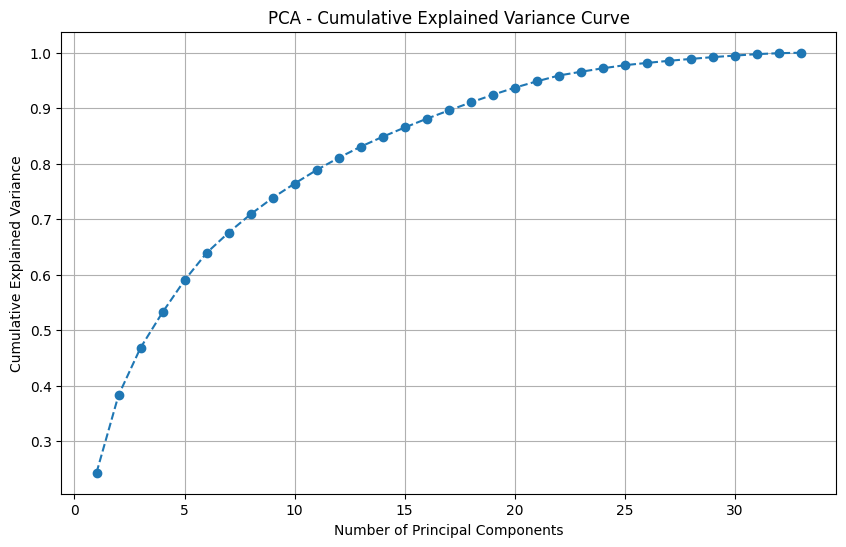

In [7]:
# Apply PCA to visualize explained variance
pca = PCA()
features_pca = pca.fit_transform(features_normalized)

# Plot cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance Curve')
plt.grid()
plt.show()


In [11]:
# Reduce dimensions using PCA
pca = PCA(n_components=20)
features_reduced = pca.fit_transform(features_normalized)

### K-Means Clustering

Experimenting with different cluster sizes yields a value of 3 clusters with a silhouette score of 0.16. This is quite low overall. The t-SNE visualization shows some separation of the clusters, but also considerable overalp. 

Silhouette Score for k=2: 0.1533833316218488
Silhouette Score for k=3: 0.16186497883922968
Silhouette Score for k=4: 0.09751693609144009
Silhouette Score for k=5: 0.10244420302530911
Silhouette Score for k=6: 0.08259942783329267
Best number of clusters based on silhouette score: 3


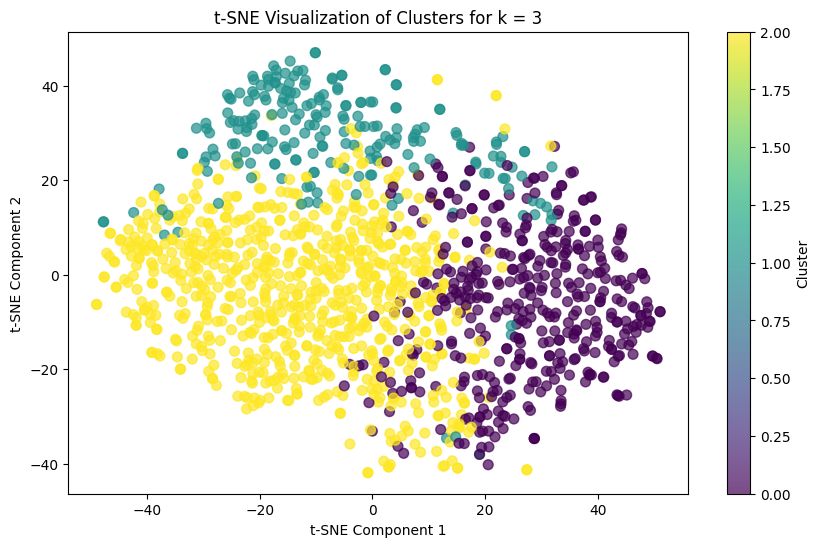

                                               Filename  Cluster
0     TRAINING_DATA/PREPARED/outro/008-20241001_me_j...        2
1     TRAINING_DATA/PREPARED/outro/004-20240929_wesu...        2
2     TRAINING_DATA/PREPARED/outro/011-20240922_wesu...        2
3     TRAINING_DATA/PREPARED/outro/009-20241021_me_a...        1
4     TRAINING_DATA/PREPARED/outro/010-20241006_wesu...        2
...                                                 ...      ...
1365  TRAINING_DATA/PREPARED/outro/007-20241005_wesa...        0
1366  TRAINING_DATA/PREPARED/outro/001-20241027_wesu...        2
1367  TRAINING_DATA/PREPARED/outro/015-20240927_me_s...        2
1368  TRAINING_DATA/PREPARED/outro/005-20241015_atc_...        2
1369  TRAINING_DATA/PREPARED/outro/002-20241102_wesa...        2

[1370 rows x 2 columns]


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Apply PCA with 20 components
pca = PCA(n_components=20)
features_reduced = pca.fit_transform(features_normalized)

# # Perform K-Means clustering
# kmeans = KMeans(n_clusters=4, random_state=42)
# labels = kmeans.fit_predict(features_reduced)

# # Evaluate clustering with silhouette score
# silhouette_avg = silhouette_score(features_reduced, labels)
# print(f'Silhouette Score for k=4: {silhouette_avg}')

# Optional: Try different values for k and select the best
best_score = -1
best_k = 4

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_reduced)
    score = silhouette_score(features_reduced, labels)
    print(f'Silhouette Score for k={k}: {score}')
    
    if score > best_score:
        best_score = score
        best_k = k

print(f'Best number of clusters based on silhouette score: {best_k}')

# Re-run K-Means with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(features_reduced)

# Visualize clusters using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f't-SNE Visualization of Clusters for k = {best_k}')
plt.colorbar(label='Cluster')
plt.show()

# Create a DataFrame to store filenames and their assigned cluster labels
import pandas as pd
results_df = pd.DataFrame({'Filename': filenames, 'Cluster': labels})
print(results_df)


### Random Sampling and Evaluation

A random sampling of tracks from each cluster shows that clusters 0 and 1 are reasonably well classified as tracks containing some musical elements, but at least 1/5 of all checked samples in both groups is contains only dialogue. Cluster 2 similarly is about 80% only dialogue, but after several rounds of random sampling, at least one track in each sample contains music. This is insufficient. 

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import Audio, display
import pandas as pd
import random

# Apply PCA with 20 components
pca = PCA(n_components=20)
features_reduced = pca.fit_transform(features_normalized)

# Perform K-Means clustering
best_k = 3  # Assuming k=3 based on previous visualization
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(features_reduced)

# Create a DataFrame to store filenames and their assigned cluster labels
results_df = pd.DataFrame({'Filename': filenames, 'Cluster': labels})

# Sample five files from each cluster and play them one at a time
for cluster_id in range(best_k):
    cluster_files = results_df[results_df['Cluster'] == cluster_id]['Filename'].tolist()
    sampled_files = random.sample(cluster_files, min(5, len(cluster_files)))  # Get up to 5 samples from the cluster

    print(f'\nPlaying 5 random samples from Cluster {cluster_id}:')
    for idx, sample_file in enumerate(sampled_files):
        print(f'Playing sample {idx + 1} from Cluster {cluster_id}: {sample_file.name}')
        display(Audio(str(sample_file)))



Playing 5 random samples from Cluster 0:
Playing sample 1 from Cluster 0: 010-20241021_me_liberty_are_wnba_champs_chunk_1.mp3


Playing sample 2 from Cluster 0: 008-20240926_me_the_reality_of_the_link_between_crime_and_homelessness_is_complex_chunk_1.mp3


Playing sample 3 from Cluster 0: 007-20241008_atc_epa_final_lead_rule_chunk_1.mp3


Playing sample 4 from Cluster 0: 014-20241017_atc_listeria_chicken_recall_chunk_1.mp3


Playing sample 5 from Cluster 0: 005-20241021_atc_sports_politics_chunk_1.mp3



Playing 5 random samples from Cluster 1:
Playing sample 1 from Cluster 1: 009-20241027_wesun_trump_and_harris_ramp_up_the_rhetoric_on_the_campaign_trail_chunk_1.mp3


Playing sample 2 from Cluster 1: 003-20241009_atc_wimbledon_robots_chunk_1.mp3


Playing sample 3 from Cluster 1: 014-20241011_me_2024_nobel_peace_prize_is_won_by_the_japanese_organization_nihon_hidankyo_chunk_1.mp3


Playing sample 4 from Cluster 1: 006-20241024_atc_a_good_guy_embedded_roll-off-atc_chunk_1.mp3


Playing sample 5 from Cluster 1: 016-20241003_me_for_women_in_the_military_seeking_an_abortion_has_become_much_more_complex_chunk_1.mp3



Playing 5 random samples from Cluster 2:
Playing sample 1 from Cluster 2: 010-20241007_me_gaza_war_sways_michigan_chunk_1.mp3


Playing sample 2 from Cluster 2: 003-20241001_atc_vance_and_walz_face_off_in_nyc_chunk_1.mp3


Playing sample 3 from Cluster 2: 005-20241003_atc_states_up_for_grabs_chunk_1.mp3


Playing sample 4 from Cluster 2: 014-20241005_wesat_saturday_sports_mlb_and_wnba_playoff_predictions_chunk_1.mp3


Playing sample 5 from Cluster 2: 004-20240928_atc_what_are_the_implications_of_the_hassan_nasrallah_assassination_chunk_1.mp3
